In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import numba
from numba import jit, cuda

In [18]:
K0 = 273.15 # 0 Celsius in Kelvin

In [3]:
@numba.jit("f8(f8)", nopython=True, nogil=True, fastmath = True)
def external_temperature(sec):
    h = sec/3600
    h = h%24
    t = 15*np.sin(np.pi*h/12 + 3.9) + 24
    return K0 + t

### Defining the problem

In [4]:
alpha = 0.27
days = 7
duration = 3600*24*days #seconds
nodes = 300

# initialize wall temperature as a gradient
# where initial inner wall is set at 25 degree Celsius
wall = np.linspace(external_temperature(0), 25+K0, nodes) 

### Solving the heat equation

In [6]:
@numba.jit("(f8[:],f8,f8,f8)", nopython=True, nogil=True, fastmath = True, cache=True)
def solve_heat_eqn(init_state, duration, dt, dx):
    wall = init_state.copy()
    counter = 0
    
    inners = []
    
    while counter < duration :
        w = wall.copy()
        for i in range(1, nodes - 1):

            wall[i] = dt * alpha * (w[i - 1] - 2 * w[i] + w[i + 1]) / dx ** 2 + w[i]

        counter += dt
        wall[0] = external_temperature(counter)
        wall[-1] = wall[-2]
        
        inners.append(wall[-1])
        
    return wall, np.array(inners)

External temperature for reference

In [7]:
def external_temperature_hour(h):
    h = h%24
    t = 15*np.sin(np.pi*h/12 + 3.9) + 24
    return t
hours_xs = np.linspace(0, 24*days, 300)

Solve heat equation for different wall thicknesses

In [31]:
def get_inner_temperatures(thickness):
    
    dx = thickness / (nodes-1)
    dt = 0.5 * dx**2 / alpha

    start = time()
    print(f'For t = {thickness} mm:\n  Iterations: {duration/dt:.0f}\n  dt = {dt:.3f} s')
    final, inners = solve_heat_eqn(wall, duration, dt, dx)
    end = time()
    print(f'  Time elapsed: {end - start:.3f} s\n')
    
    N = len(inners)
    if N > 1e5:
        k = int(N//1e5)
        inners = inners[::k]
        
    return inners   

In [38]:
thicknesses = {150:[], 120:[], 100:[], 200:[]}
for thickness in thicknesses:
    thicknesses[thickness] = get_inner_temperatures(thickness)

For t = 150 mm:
  Iterations: 1297673
  dt = 0.466 s
  Time elapsed: 0.575 s

For t = 120 mm:
  Iterations: 2027615
  dt = 0.298 s
  Time elapsed: 0.924 s

For t = 100 mm:
  Iterations: 2919765
  dt = 0.207 s
  Time elapsed: 1.333 s

For t = 200 mm:
  Iterations: 729941
  dt = 0.829 s
  Time elapsed: 0.330 s



Plotting inner temperatures

In [37]:
variations = {}

Temperature variation: 18.56 to 29.44 Celsius (10.87)
Temperature variation: 16.07 to 31.93 Celsius (15.86)
Temperature variation: 13.94 to 34.06 Celsius (20.13)
Temperature variation: 21.00 to 26.96 Celsius (5.96)


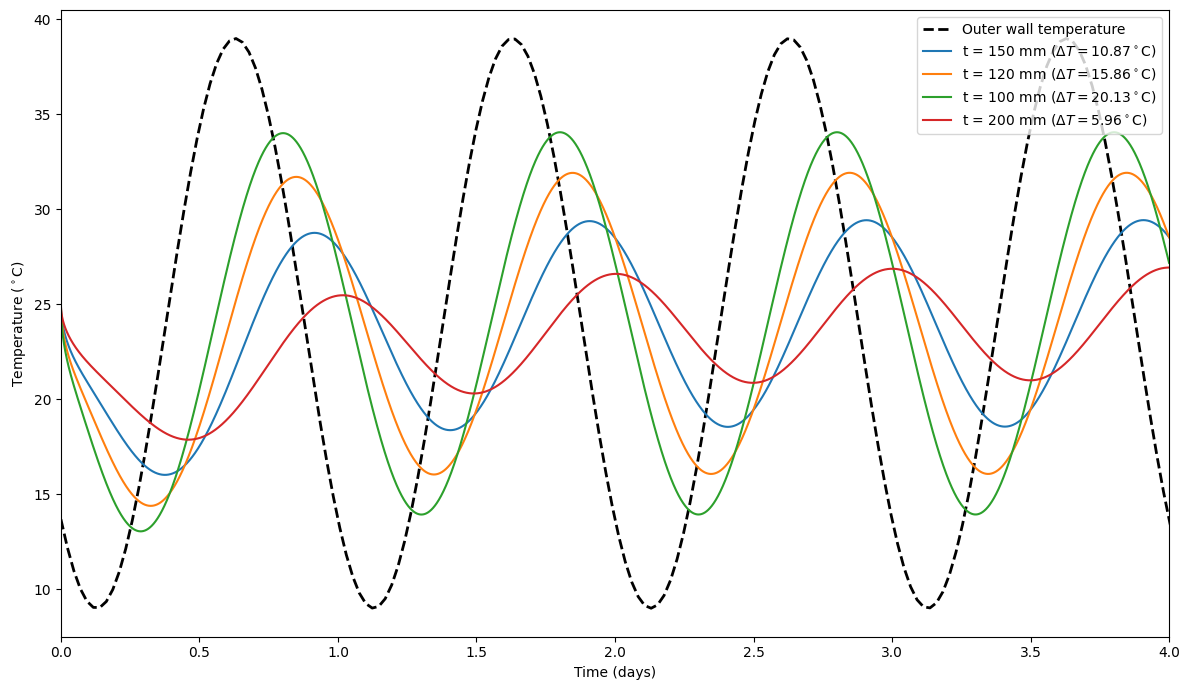

In [39]:
plt.figure(figsize=(12,7))
plt.plot(hours_xs/24, external_temperature_hour(hours_xs), 'k--', label='Outer wall temperature', alpha=1, linewidth=2)

for thickness in thicknesses:
    inner_temps = thicknesses[thickness]-K0
    xss = np.linspace(0, duration/3600, len(inner_temps))
    
    stable_region = int(len(inner_temps)/2)
    maxT = np.max(inner_temps[stable_region:])
    minT = np.min(inner_temps[stable_region:])
    print(f'Temperature variation: {minT:.2f} to {maxT:.2f} Celsius ({maxT-minT:.2f})')
    
    variations[thickness] = maxT-minT
    plt.plot(xss/24, inner_temps, label=f't = {thickness} mm ('+r"$\Delta T =$"+f'{round(maxT-minT,2)}'+r"$^\circ$C)")
    
plt.ylabel(r'Temperature ($^\circ$C)')
plt.xlabel('Time (days)')
plt.xlim(0,4)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('plots/4/var0.png', dpi=200)

Narrow down the temperature range

In [61]:
thicknesses = {180:[], 190:[], 200:[], 210:[], 220:[]}
for thickness in thicknesses:
    thicknesses[thickness] = get_inner_temperatures(thickness)

For t = 180 mm:
  Iterations: 901162
  dt = 0.671 s
  Time elapsed: 0.413 s

For t = 190 mm:
  Iterations: 808799
  dt = 0.748 s
  Time elapsed: 0.360 s

For t = 200 mm:
  Iterations: 729941
  dt = 0.829 s
  Time elapsed: 0.324 s

For t = 210 mm:
  Iterations: 662078
  dt = 0.913 s
  Time elapsed: 0.298 s

For t = 220 mm:
  Iterations: 603257
  dt = 1.003 s
  Time elapsed: 0.271 s



Temperature variation: 20.24 to 27.76 Celsius (7.52)
Temperature variation: 20.66 to 27.33 Celsius (6.67)
Temperature variation: 21.00 to 26.96 Celsius (5.96)
Temperature variation: 21.31 to 26.63 Celsius (5.32)
Temperature variation: 21.57 to 26.34 Celsius (4.76)


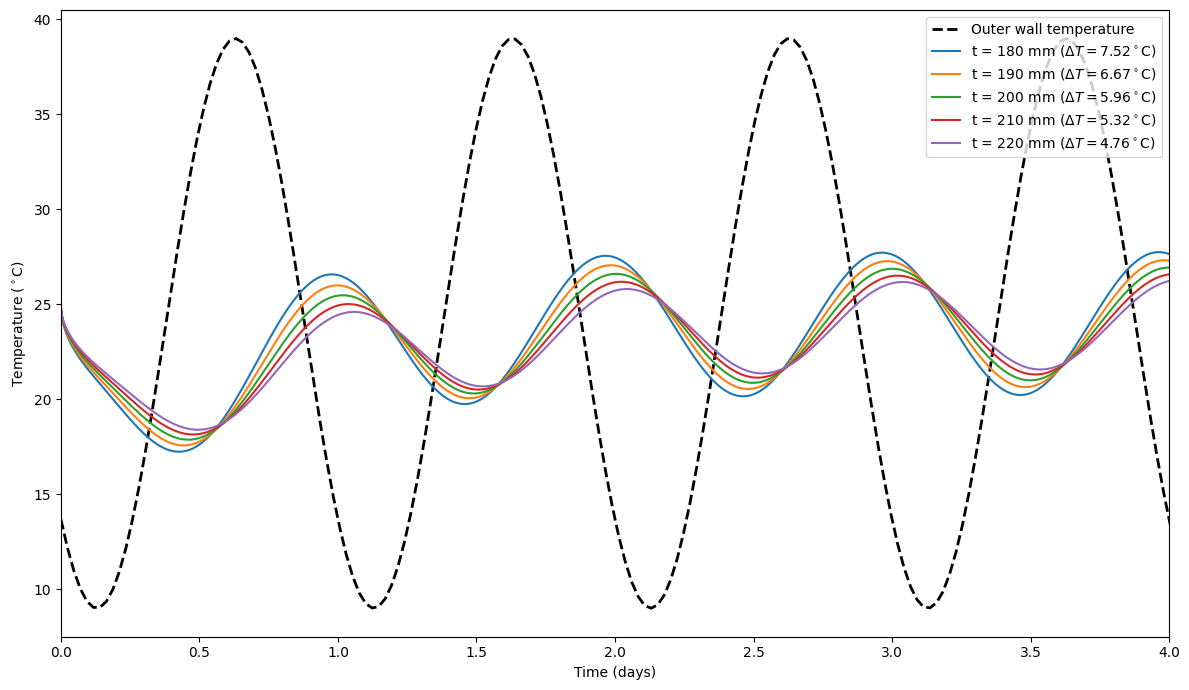

In [62]:
plt.figure(figsize=(12,7))
plt.plot(hours_xs/24, external_temperature_hour(hours_xs), 'k--', label='Outer wall temperature', alpha=1, linewidth=2)

for thickness in thicknesses:
    inner_temps = thicknesses[thickness]-K0
    xss = np.linspace(0, duration/3600, len(inner_temps))
    
    stable_region = int(len(inner_temps)/2)
    maxT = np.max(inner_temps[stable_region:])
    minT = np.min(inner_temps[stable_region:])
    print(f'Temperature variation: {minT:.2f} to {maxT:.2f} Celsius ({maxT-minT:.2f})')
    
    variations[thickness] = maxT-minT
    plt.plot(xss/24, inner_temps, label=f't = {thickness} mm ('+r"$\Delta T =$"+f'{round(maxT-minT,2)}'+r"$^\circ$C)")
    
plt.ylabel(r'Temperature ($^\circ$C)')
plt.xlabel('Time (days)')
plt.xlim(0,4)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('plots/4/var1.png', dpi=200)

### $\Delta T$ vs Thickness

As we can see that the temperature variations around 200 mm get close to the human comfort range. Let us now plot $\Delta T$ vs thickness.

In [47]:
thicknesses = [T for T in range(170, 300, 10)]
for thickness in thicknesses:
    inner_temps = get_inner_temperatures(thickness)
    stable_region = int(len(inner_temps)/2)
    maxT = np.max(inner_temps[stable_region:])
    minT = np.min(inner_temps[stable_region:])
    
    variations[thickness] = maxT-minT

For t = 170 mm:
  Iterations: 1010299
  dt = 0.599 s
  Time elapsed: 0.456 s

For t = 180 mm:
  Iterations: 901162
  dt = 0.671 s
  Time elapsed: 0.402 s

For t = 190 mm:
  Iterations: 808799
  dt = 0.748 s
  Time elapsed: 0.360 s

For t = 200 mm:
  Iterations: 729941
  dt = 0.829 s
  Time elapsed: 0.325 s

For t = 210 mm:
  Iterations: 662078
  dt = 0.913 s
  Time elapsed: 0.295 s

For t = 220 mm:
  Iterations: 603257
  dt = 1.003 s
  Time elapsed: 0.270 s

For t = 230 mm:
  Iterations: 551940
  dt = 1.096 s
  Time elapsed: 0.247 s

For t = 240 mm:
  Iterations: 506904
  dt = 1.193 s
  Time elapsed: 0.227 s

For t = 250 mm:
  Iterations: 467162
  dt = 1.295 s
  Time elapsed: 0.207 s

For t = 260 mm:
  Iterations: 431918
  dt = 1.400 s
  Time elapsed: 0.189 s

For t = 270 mm:
  Iterations: 400516
  dt = 1.510 s
  Time elapsed: 0.177 s

For t = 280 mm:
  Iterations: 372419
  dt = 1.624 s
  Time elapsed: 0.164 s

For t = 290 mm:
  Iterations: 347178
  dt = 1.742 s
  Time elapsed: 0.153 s

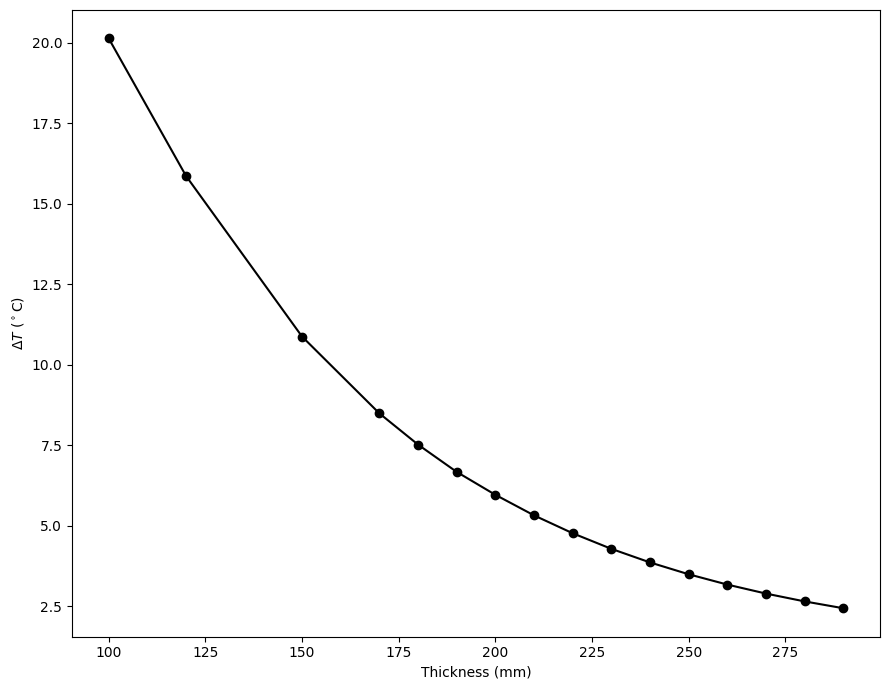

In [60]:
plt.figure(figsize=(9,7))
variations = dict(sorted(variations.items()))
plt.plot(variations.keys(), variations.values(), '-ko')
plt.ylabel(r'$\Delta T$ ($^\circ$C)')
plt.xlabel('Thickness (mm)')
plt.tight_layout()
plt.savefig('plots/4/var_fin.png', dpi=200)